# A Tutorial on Generating a Synthetic Dataset for cSPI

The purpose of this tutorial is to generate a synthetic dataset of diffraction patterns and their associated orientations for computational Single Particle Imaging (cSPI). The tutorial first introduces steps on installing Pysingfel, a Python-based SPI Simulation for Free-Electron Lasers. The tutorial then setups and simulates an SPI Experiment. Lastly, a synthetic dataset is created from the diffraction patterns and orientations collected from the experiment.

## Gather dependencies for the SPI Experiment

### Install Pysingfel on PSLogin 

1. ```ssh``` into your pslogin home

2. clone the Pysingfel repository using ```git```

```bash
git clone https://github.com/fredericpoitevin/pysingfel.git
```

3. Update ```~/.bashrc``` with ```source /reg/g/psdm/etc/psconda.sh```

4. Reload ```~/.bashrc```

```bash
source ~/.bashrc
```

5. Change the current directory to the ```pysingfel``` directory

```bash
cd pysingfel
```

6. Install Pysingfel

```bash
python setup.py install --user
```

7. Change the current directory to the ```input``` directory

```bash
cd examples/input
```

8. Download a copy of ```lcls.tar.gz``` from ```https://stanford.box.com/s/e7c30tvhfz0485j2xr48rnrvel8a4yby```

```bash
wget https://stanford.box.com/s/e7c30tvhfz0485j2xr48rnrvel8a4yby -O lcls.zip
```

9. Unzip the contents using ```tar```

```bash
tar -xvf lcls.tar.gz
```

10. Navigate to https://pswww.slac.stanford.edu/ in your browser

11. Open a notebook from the ```examples``` directory and get acquainted with the simulator

### Import dependencies

We first configure the notebook to display figures.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

We then import the following python dependencies.

In [2]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import h5py as h5
import time, os
from scipy import ndimage
from pysingfel import *
import pysingfel as ps
from pysingfel.particlePlacement import position_in_3d

## Perform the SPI Experiment

### Set up the SPI Experiment

We define paths to the files containing the PDB, beam, and detector geometry that we will use for the experiment.

In [3]:
input_dir='../input'
pdbfile=input_dir+'/pdb/3iyf.pdb'
beamfile=input_dir+'/beam/amo86615.beam'
geom=input_dir+'/lcls/amo86615/PNCCD::CalibV1/Camp.0:pnCCD.1/geometry/0-end.data'

We build a particle from the PDB file.

In [4]:
particle = ps.Particle()
particle.read_pdb(pdbfile, ff='WK')

We apply a hydration layer to the particle.

In [5]:
hydration_layer_thickness = 10.0 / 10**10
mesh_voxel_size           = 2.0 / 10**10

In [6]:
particle.set_hydration_layer_thickness(hydration_layer_thickness)
particle.set_mesh_voxel_size(mesh_voxel_size)
particle.get_masks()

We build the beam out of the beam file.

In [7]:
beam = ps.Beam(beamfile)

We build the pnCCD detector using the detector geometry and beam. 

In [8]:
det = ps.PnccdDetector(geom=geom, beam=beam)

### Establishing the relation between the detector and reciprocal space

From this geometry, the relationship between the
detector and the reciprocal space is given by 
$$q = \frac{2}{\lambda} \sin \theta$$
$$q_x = q(1 - \frac{\lambda^2 q^2}{4})^\frac{1}{2} \sin (\arctan2(x, y))$$
$$q_y = q(1 - \frac{\lambda^2 q^2}{4})^\frac{1}{2} \cos (\arctan2(x, y))$$
$$q_z = -\frac{\lambda}{2}q^2$$
$$\vec{q} = (q_x, q_y, q_z) = \vec{k}_{out} - \vec{k}_{in}$$
where $\vec{q}$ is the scattering vector, $\lambda$ is the wavelength, and $2\theta$ is the angle between the incident and scattered wave vector $k_{in}$ and $k_{out}$, respectively. The coordinates $(x, y)$ denote the position of the detector pixel, which has a corresponding point $(q_x, q_y, q_z)$ in reciprocal space located on the Ewald sphere. [[1]](#[1])

<center>
    <a><img src="images/cspi_generate_synthetic_dataset_Fig1.png" /></a>
</center>

### Determining the photon count for a pixel on the detector

If $D$ is the particle diameter, $\Phi$ is the incident flux, $o$ is the oversampling ratio, and $r_e$ is the electron radius, then the expected photon count $n(q)$ for a pixel on the detector
can then be determined by
$$n(q) = \Phi r_e^2 |F(\vec{q})|^2\left(\frac{\lambda}{oD}\right)^2$$
for small scattering angles $2\theta$ where
$$F(\vec{q}) = \sum_{j=1}^N f_j(q) \exp (2 \pi i \vec{q} \cdot X_j')$$
and
$$X_j' = RX_j$$
$R$ here is the matrix that rotates the particle, represented by the three-dimensional atomic coordinates $X_j=\{(x_j, y_j, z_j)\}$, to a new position $X_j'=\{(x'_j,y'_j,z'_j)\}$. [[1]](#[1])

### Simulate the SPI Experiment

In this simulated SPI experiment, a large number of two-dimensional diffraction patterns of the particle will be recorded by the pnCCD detector. These diffraction patterns are often noisy and taken in random orientations. [[1]](#[1])

In [9]:
experiment = ps.SPIExperiment(det, beam, particle)

## Create the synthetic dataset

### Collect the diffraction patterns and orientations

We define $k$ as the number of diffraction patterns to collect from the experiment.

In [10]:
k = 3

We collect $k$ diffraction patterns and their respective orientations.

In [11]:
for i in range(k):
    orientation = experiment.get_next_orientation()[0]
    diffraction_pattern = experiment.generate_image()
    if i == 0:
        diffraction_patterns = np.zeros((k,) + diffraction_pattern.shape)
        orientations = np.zeros((k,) + orientation.shape)
    orientations[i] = orientation
    diffraction_patterns[i] = diffraction_pattern

We display the shape of the diffraction patterns and orientations.

In [12]:
"diffraction_patterns shape: {}".format(diffraction_patterns.shape)

'diffraction_patterns shape: (3, 1024, 1040)'

Orientations are quaternions that represent a 3D rotation.

In [13]:
"orientations shape: {}".format(orientations.shape)

'orientations shape: (3, 4)'

### Visualize the diffraction patterns

We plot the diffraction patterns in $\log$ scale. 

In [14]:
viz = ps.Visualizer(experiment, diffraction_rings="auto", log_scale=True)

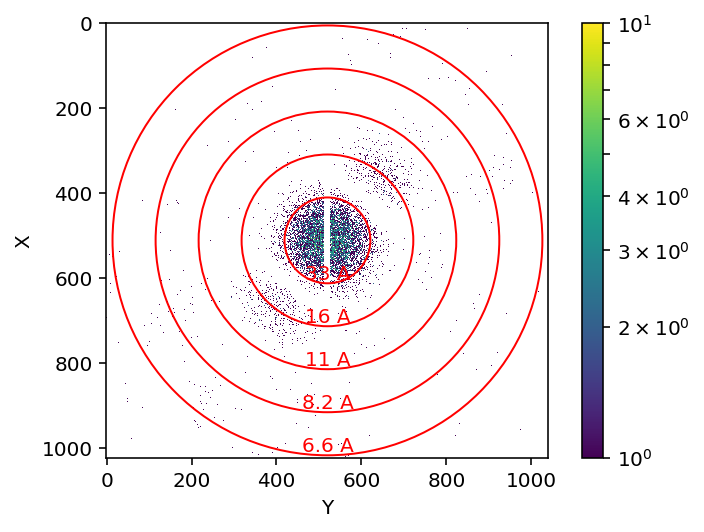

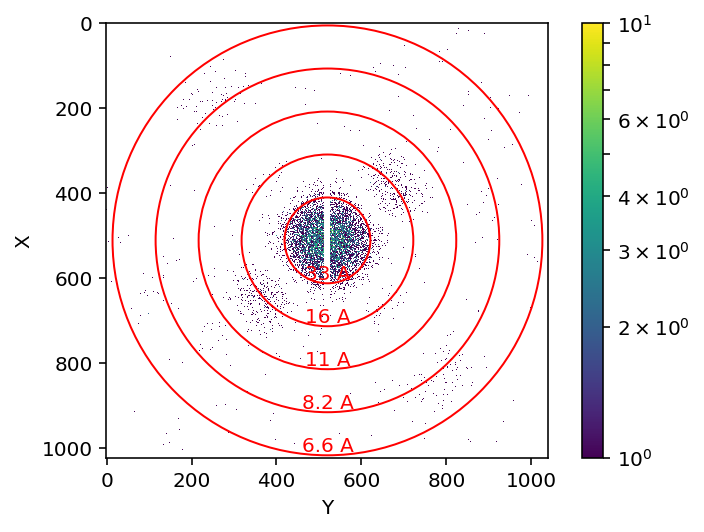

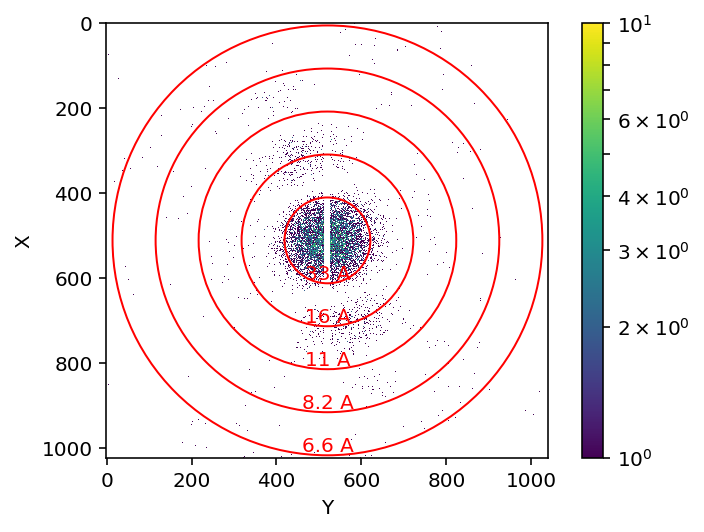

In [15]:
for diffraction_pattern in diffraction_patterns:
    plt.figure()
    viz.imshow(diffraction_pattern)

### Save the diffraction patterns and orientations

We will save the diffraction patterns and orientations collected from the experiment to an output directory.
If the output directory does not exist, we create one.

In [16]:
output_dir = '../output'
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

We define file paths for the diffraction patterns and orientations. Note that we will save the data as NPY files.

In [24]:
cspi_synthetic_dataset_diffraction_patterns_file = os.path.join(output_dir, 'cspi_synthetic_dataset_diffraction_patterns_{}x{}.npy'.format(diffraction_patterns.shape[1], diffraction_patterns.shape[2]))
cspi_synthetic_dataset_orientations_file = os.path.join(output_dir, 'cspi_synthetic_dataset_orientations.npy')

In [25]:
cspi_synthetic_dataset_diffraction_patterns_file

'../output/cspi_synthetic_dataset_diffraction_patterns_1024x1040.npy'

In [26]:
cspi_synthetic_dataset_orientations_file

'../output/cspi_synthetic_dataset_orientations.npy'

We then save the diffraction patterns and orientations to the output directory.

In [27]:
np.save(cspi_synthetic_dataset_diffraction_patterns_file, diffraction_patterns)

In [28]:
np.save(cspi_synthetic_dataset_orientations_file, orientations)

We verify by reloading the saved data.

In [29]:
np.load(cspi_synthetic_dataset_diffraction_patterns_file).shape

(3, 1024, 1040)

In [30]:
np.load(cspi_synthetic_dataset_orientations_file).shape

(3, 4)

## References

<a id="[1]">[1]</a> I. Poudyal, M. Schmidt, and P. Schwander, “Single-particle imaging by x-ray free-electron lasers—How many snapshots are needed?,” Structural Dynamics, vol. 7, no. 2, p. 24102, Mar. 2020.